In [2]:
import torch
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
from datasets import load_dataset


device = "mps"

/Users/aszab/EDU/CAM/modules/L46/project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast


model_path = "/Users/aszab/repos/models/gpt2"
model = GPT2LMHeadModel.from_pretrained(model_path).to(device)

tokenizer = GPT2TokenizerFast.from_pretrained(model_path)

if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

In [8]:
from transformers import LlamaForCausalLM, LlamaTokenizerFast

model_path = "/Users/aszab/repos/models/Llama-3.2-1B"
model = LlamaForCausalLM.from_pretrained(model_path).to(device)

tokenizer = LlamaTokenizerFast.from_pretrained(model_path)

if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'LlamaTokenizerFast'.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


In [3]:
from transformers import Gemma2ForCausalLM, AutoTokenizer, HybridCache

model_path = "/Users/aszab/repos/models/gemma-2-2b"
model = Gemma2ForCausalLM.from_pretrained(model_path).to(device)

tokenizer = AutoTokenizer.from_pretrained(model_path)

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  7.81it/s]


In [4]:
inputs = tokenizer("Hello, my dog is cute and", return_tensors="pt").to(device)

outputs = model(
    **inputs,
    # pad_token_id=model.config.pad_token_id
    labels=inputs["input_ids"],
)
past_key_values = outputs.past_key_values
pred_token_idx = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


In [143]:
outputs.loss

tensor(4.6559, device='mps:0', grad_fn=<NllLossBackward0>)

In [144]:
pred_token_idx

tensor([[590]], device='mps:0')

In [23]:
test = load_dataset(
    "wikitext", "wikitext-2-raw-v1", split="test", cache_dir="~/repos/datasets"
)
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

Token indices sequence length is longer than the specified maximum sequence length for this model (287644 > 1024). Running this sequence through the model will result in indexing errors


In [59]:
print(encodings.input_ids[:, :10])

max_seq_len = encodings.input_ids.size(1)

num_passes = 1
chunk_len = 2048
shift_len = 50

assert num_passes * chunk_len <= max_seq_len
seq_len = shift_len * num_passes
print(f"chunk_len: {chunk_len}")

global_nlls = []
global_generation_time = []
global_past_key_values_size = []
loss_fn = torch.nn.CrossEntropyLoss(reduction="none")


for begin_idx in range(0, seq_len, shift_len):
    end_idx = min(begin_idx + chunk_len, max_seq_len)
    print(f"{begin_idx=}, {end_idx=}")

    pbar = tqdm(range(begin_idx, end_idx - 1))

    if isinstance(model, Gemma2ForCausalLM):
        past_key_values = HybridCache(
            config=model.config,
            batch_size=1,
            max_cache_len=chunk_len,
            device=model.device,
            dtype=model.dtype,
        )
    else:
        past_key_values = None

    nlls = []
    generation_time = []
    past_key_values_size = []

    for idx in pbar:
        input_ids = encodings.input_ids[:, idx : idx + 1].to(device)
        with torch.no_grad():

            start_time = time.time()
            outputs = model(
                input_ids,
                past_key_values=past_key_values,
                use_cache=True,
            )

            generation_time.append(time.time() - start_time)

            logits = outputs.logits.view(-1, model.config.vocab_size)
            label = encodings.input_ids[:, idx + 1 : idx + 2].to(logits.device).view(-1)
            neg_log_likelihood = loss_fn(logits, label)
            past_key_values = outputs.past_key_values

            if isinstance(model, Gemma2ForCausalLM):
                past_key_values_size.append(
                    sum(
                        sum([p_i.numel() * p_i.element_size() for p_i in p])
                        for p in [
                            *past_key_values.key_cache,
                            *past_key_values.value_cache,
                        ]
                    )
                )

            else:
                past_key_values_size.append(
                    sum(
                        sum([p_i.numel() * p_i.element_size() for p_i in p])
                        for p in past_key_values
                    )
                )

            if torch.backends.mps.is_available():
                torch.mps.empty_cache()

        nlls.append(neg_log_likelihood)
        pbar.set_description(
            f"nll: {neg_log_likelihood.item():.2f}, ppl: {torch.exp(neg_log_likelihood).item():.2f}"
        )
    global_nlls.append(nlls)
    global_generation_time.append(generation_time)
    global_past_key_values_size.append(past_key_values_size)

tensor([[ 628,  796, 5199,  347, 2852,  353,  796,  220,  628,  628]])
chunk_len: 2028
begin_idx=0, end_idx=2028


nll: 9.43, ppl: 12511.11: 100%|██████████| 2027/2027 [00:47<00:00, 42.89it/s]       


In [60]:
nlls = torch.tensor(global_nlls).mean(dim=0)
past_key_values = torch.tensor(global_past_key_values_size, dtype=torch.float64).mean(
    dim=0
)

In [105]:
past_key_values_size[0]

73728

In [11]:
torch.mps.empty_cache()

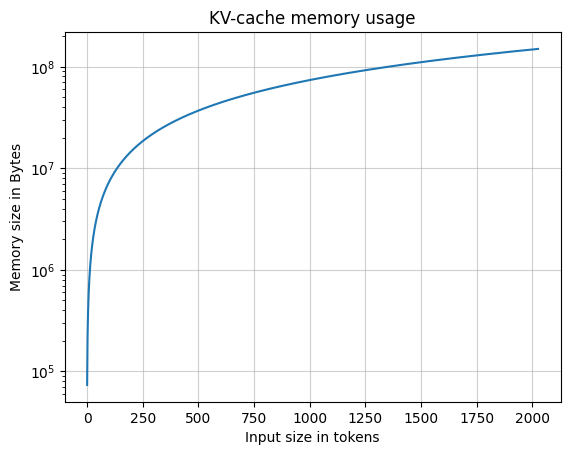

In [61]:
plt.plot(range(len(nlls)), torch.tensor(past_key_values_size))
plt.yscale("log")
plt.title("KV-cache memory usage")
plt.xlabel("Input size in tokens")
plt.ylabel("Memory size in Bytes")
plt.grid(alpha=0.6, zorder=1)

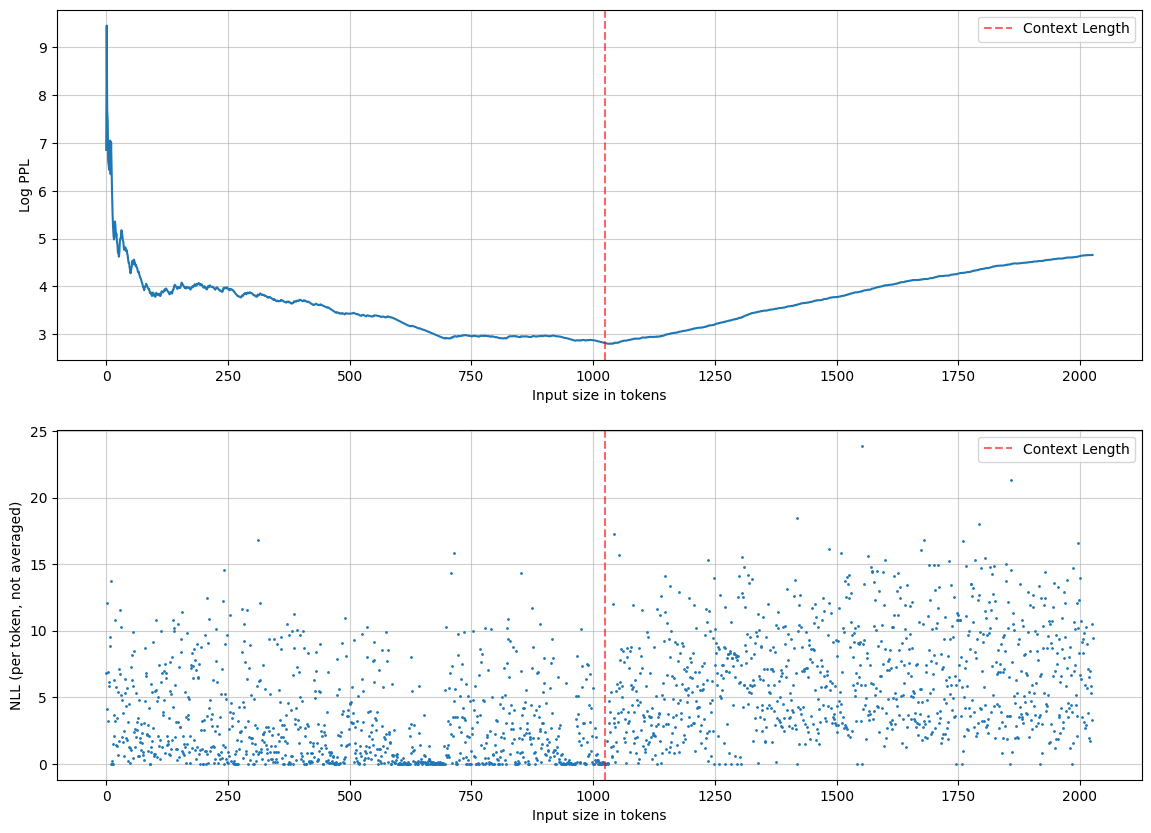

In [64]:
t = nlls

fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(
    range(len(nlls)),
    [t[: i + 1].mean() for i in range(len(nlls))],
)
ax[0].axvline(
    x=model.config.max_position_embeddings,
    color="red",
    linestyle="--",
    alpha=0.6,
    label="Context Length",
)
ax[0].set_ylabel("Log PPL")
ax[0].set_xlabel("Input size in tokens")
ax[0].grid(alpha=0.6, zorder=1)
ax[0].legend()

ax[1].plot(
    range(len(nlls)),
    [(t[i]) for i in range(len(nlls))],
    "o",
    # color="red",
    # linewidth=0.1,
    markersize=1,
)
ax[1].axvline(
    x=model.config.max_position_embeddings,
    color="red",
    linestyle="--",
    alpha=0.6,
    label="Context Length",
)
ax[1].set_ylabel("NLL (per token, not averaged)")
ax[1].set_xlabel("Input size in tokens")
ax[1].grid(alpha=0.6, zorder=1)
ax[1].legend()

## GPT2 results

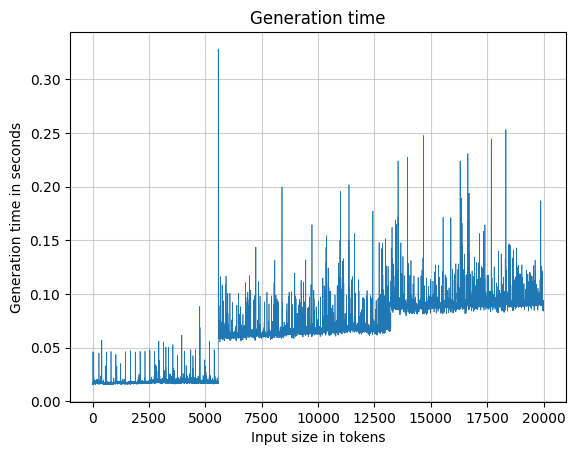

In [138]:
plt.plot(range(len(nlls)), generation_time, linewidth=0.5)
plt.title("Generation time")
plt.xlabel("Input size in tokens")
plt.ylabel("Generation time in seconds")
plt.grid(alpha=0.6, zorder=1)

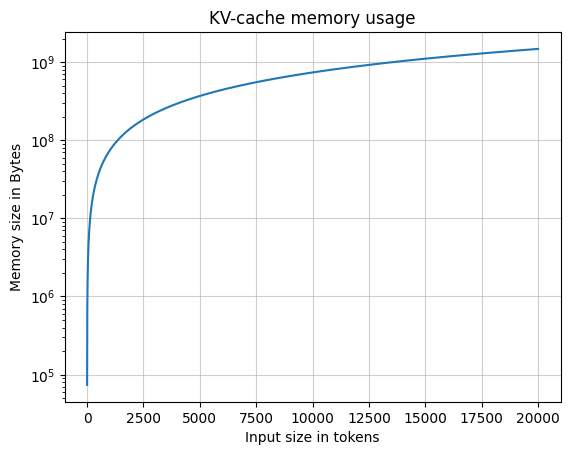

In [139]:
plt.plot(range(len(nlls)), torch.tensor(past_key_values_size))
plt.yscale("log")
plt.title("KV-cache memory usage")
plt.xlabel("Input size in tokens")
plt.ylabel("Memory size in Bytes")
plt.grid(alpha=0.6, zorder=1)

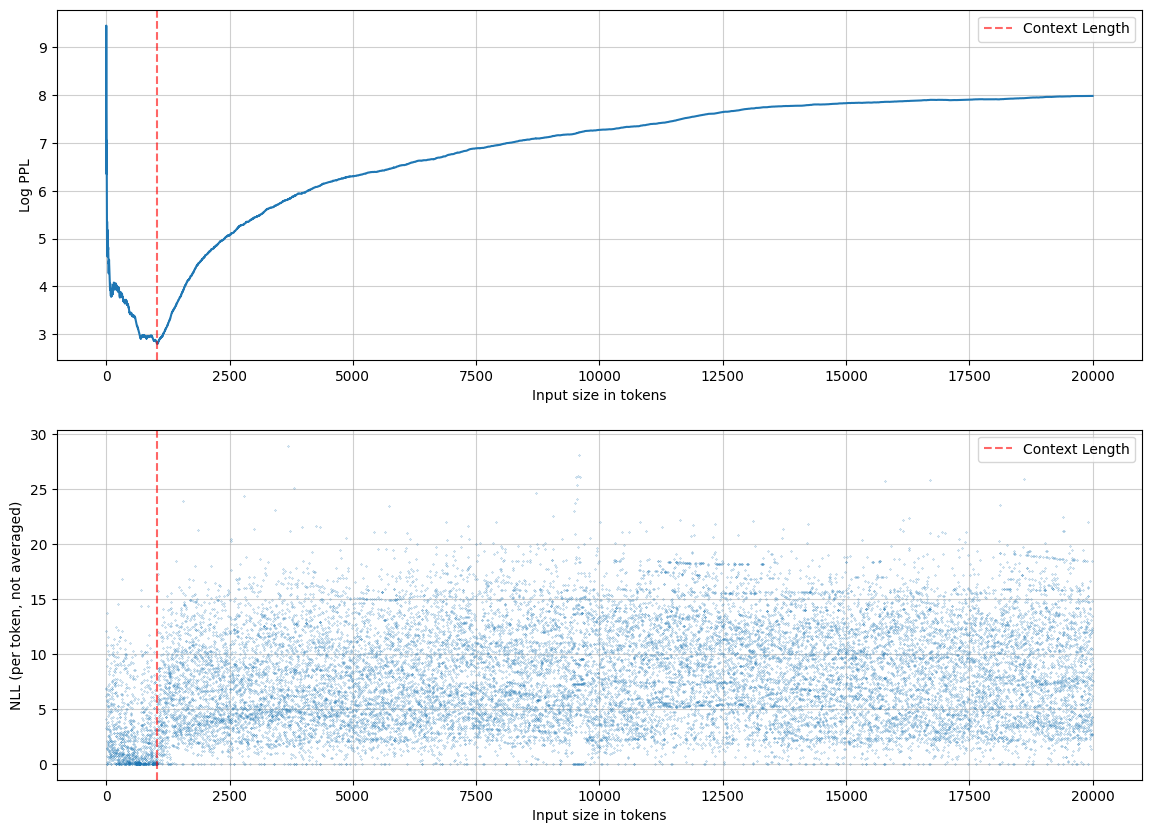

In [135]:
from matplotlib import pyplot as plt

t = torch.stack(nlls).cpu()

fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(
    range(len(nlls)),
    [t[: i + 1].mean() for i in range(len(nlls))],
)
ax[0].axvline(x=1024, color="red", linestyle="--", alpha=0.6, label="Context Length")
ax[0].set_ylabel("Log PPL")
ax[0].set_xlabel("Input size in tokens")
ax[0].grid(alpha=0.6, zorder=1)
ax[0].legend()

ax[1].plot(
    range(len(nlls)),
    [(t[i]) for i in range(len(nlls))],
    "o",
    # color="red",
    # linewidth=0.1,
    markersize=0.2,
)
ax[1].axvline(x=1024, color="red", linestyle="--", alpha=0.6, label="Context Length")
ax[1].set_ylabel("NLL (per token, not averaged)")
ax[1].set_xlabel("Input size in tokens")
ax[1].grid(alpha=0.6, zorder=1)
ax[1].legend()

In [52]:
torch.mps.empty_cache()

In [ ]:
ppls = []
# max_lenghts = [16, 32, 64, 128, 256, 512, 1024]
max_lenghts = list(range(5, 1024))
stride = 1
seq_len = encodings.input_ids.size(1)
# seq_len = 2048

nll_sum = 0.0
n_tokens = 0
prev_end_loc = 0
# for begin_loc in tqdm(range(0, seq_len, stride)):
begin_loc = 0
end_loc = min(begin_loc + max_length, seq_len)
trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
# print(trg_len)
input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
target_ids = input_ids.clone()
target_ids[:, :-trg_len] = -100
past_key_values = None

for max_length in tqdm(max_lenghts):

    with torch.no_grad():
        outputs = model(input_ids[:,], past_key_values=past_key_values)

        past_key_values = outputs.past_key_values
        print(
            outputs.logits.shape,
            outputs.logits.view(-1, model.config.vocab_size).shape,
            target_ids[:, 1:].view(-1),
        )
        neg_log_likelihood = torch.nn.CrossEntropyLoss(reduction="none")(
            outputs.logits[:, :-1, :], target_ids[:, 1:]
        )

    torch.mps.empty_cache()

    ppl = torch.exp(neg_log_likelihood)

    ppls.append(ppl.item())

In [ ]:
plt.plot(
    max_lenghts,
    [torch.log(torch.tensor(ppl)) for ppl in ppls],
)

In [ ]:
from matplotlib import pyplot as plt

plt.plot(max_lenghts, ppls)

In [ ]:
from matplotlib import pyplot as plt

plt.plot(max_lenghts, torch.log(torch.tensor(ppls)))